In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import ml libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, precision_recall_curve, fbeta_score
from imblearn.metrics import classification_report_imbalanced

from collections import Counter

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset and peeking few rows
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Feature Engineering

In [3]:
# upsampling the time feature to minutes and hours
dfFe = df.copy()
delta = pd.to_timedelta(dfFe['Time'], unit='s')
dfFe['Time_minutes'] = (delta.dt.components.minutes).astype(int)
dfFe['Time_hours'] = (delta.dt.components.hours).astype(int)

# taking a look at the new features
dfFe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_minutes,Time_hours
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0


In [4]:
# amount feature is not a good scaled - log(Amount)
# adding 0.0001 to handle negative values
print('Amount before transformation: ')
print(dfFe.Amount.head())
dfFe.Amount = np.log(dfFe.Amount+0.0001)
print('Amount after transformation: ')
print(dfFe.Amount.head())

Amount before transformation: 
0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
Name: Amount, dtype: float64
Amount after transformation: 
0    5.008099
1    0.989578
2    5.936639
3    4.816242
4    4.248354
Name: Amount, dtype: float64


### Evaluation metrics - adding function

In [5]:
def printMetrics(title, true, pred):
    print(title)
    print('Accuracy: {}'.format(accuracy_score(true, pred)))
    print('Precision: {}'.format(precision_score(true, pred)))
    print('Recall: {}'.format(recall_score(true, pred)))
    print('F2: {}'.format(fbeta_score(true, pred, beta=2)))

### Preprocessing + Handling Imbalanced data

In [6]:
# seperating target and features for modeling
X = dfFe.drop(['Class'], axis=1).values
y = dfFe.Class.values

In [7]:
# Classes before SMOTE
Counter(y)

Counter({0: 284315, 1: 492})

In [8]:
# classes after SMOTE
X_smote, y_smote = SMOTE().fit_sample(X, y)

Counter(y_smote)

Counter({0: 284315, 1: 284315})

- The dataset is balanced after SMOTE transformation

In [9]:
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

### Modeling

####  Model - Random Forest

In [10]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)

In [11]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, rf_prediction))

Confusion Matrix: 
[[56867     1]
 [   19    75]]


In [12]:
print('RF score: {}'.format(rf.score(X_test, y_test)))

RF score: 0.9996488887328394


In [13]:
printMetrics('RF evaluation results', y_test, rf_prediction)

RF evaluation results
Accuracy: 0.9996488887328394
Precision: 0.9868421052631579
Recall: 0.7978723404255319
F2: 0.8296460176991151


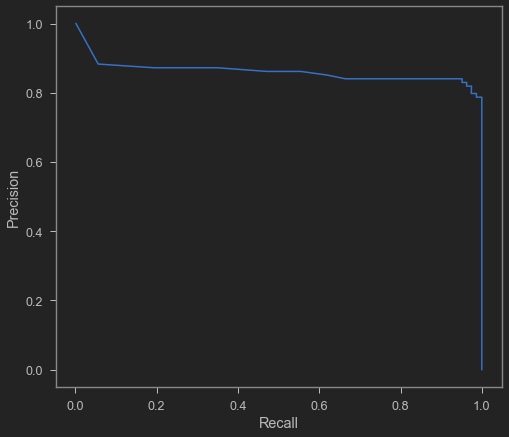

In [14]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

####  Model - Random Forest + SMOTE

In [15]:
classifier = RandomForestClassifier
# SMOTE pipeline
smote_pipeline = make_pipeline(
    SMOTE(random_state=5), classifier(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

In [16]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, smote_prediction))

Confusion Matrix: 
[[56863     5]
 [   17    77]]


In [17]:
print('SMOTE pipeline score: {}'.format(smote_pipeline.score(X_test, y_test)))

SMOTE pipeline score: 0.9996137776061234


In [18]:
printMetrics('SMOTE + RF evaluation results', y_test, smote_prediction)

SMOTE + RF evaluation results
Accuracy: 0.9996137776061234
Precision: 0.9390243902439024
Recall: 0.8191489361702128
F2: 0.8406113537117905


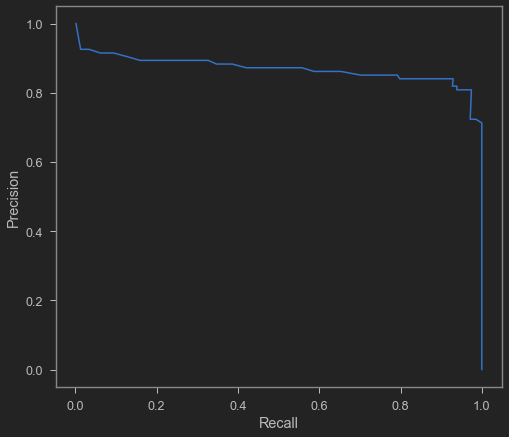

In [19]:
y_pred_proba = smote_pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### Grid Search - Random Forest

In [20]:
param_grid = {'max_depth':[3,5, None],
             'n_estimators':[3,5,7,10],
             'max_features':[5,6,7,8]}

model = RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, None],
                         'max_features': [5, 6, 7, 8],
                         'n_estimators': [3, 5, 7, 10]},
             scoring='recall')

In [21]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7763924050632912
{'max_depth': None, 'max_features': 5, 'n_estimators': 7}


In [22]:
rf_grid = RandomForestClassifier(max_depth=None, max_features=5, n_estimators=7)
rf_grid.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=7)

In [23]:
rf_grid_prediction = rf_grid.predict(X_test)

In [24]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, rf_grid_prediction))

Confusion Matrix: 
[[56866     2]
 [   20    74]]


In [25]:
print('RF-GridSearch score: {}'.format(rf_grid.score(X_test, y_test)))

RF-GridSearch score: 0.9996137776061234


In [27]:
printMetrics('RF-GridSearch evaluation results', y_test, rf_grid_prediction)

RF-GridSearch evaluation results
Accuracy: 0.9996137776061234
Precision: 0.9736842105263158
Recall: 0.7872340425531915
F2: 0.8185840707964602


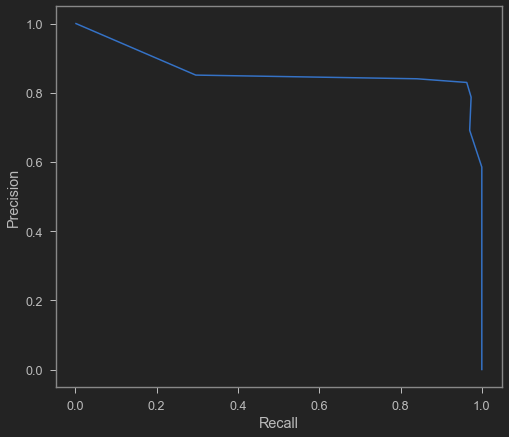

In [28]:
y_pred_proba = rf_grid.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### RF-GridSearch + SMOTE

In [29]:
# SMOTE pipeline
smote_pipeline = make_pipeline(
    SMOTE(random_state=5), rf_grid)
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

In [30]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, smote_prediction))

Confusion Matrix: 
[[56861     7]
 [   15    79]]


In [31]:
print('SMOTE pipeline score: {}'.format(smote_pipeline.score(X_test, y_test)))

SMOTE pipeline score: 0.9996137776061234


In [32]:
printMetrics('SMOTE + RF-GridSearch evaluation results', y_test, smote_prediction)

SMOTE + RF-GridSearch evaluation results
Accuracy: 0.9996137776061234
Precision: 0.9186046511627907
Recall: 0.8404255319148937
F2: 0.8549783549783551


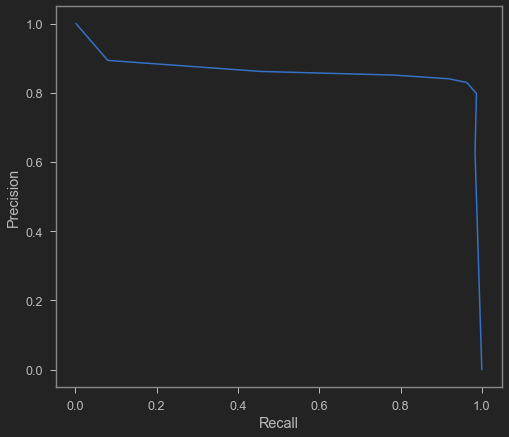

In [33]:
y_pred_proba = smote_pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Results

**RF evaluation results:**
- Accuracy: 0.9996488887328394
- Precision: 0.9868421052631579
- Recall: 0.7978723404255319
- F2: 0.8296460176991151


**SMOTE + RF evaluation results:**
- Accuracy: 0.9996137776061234
- Precision: 0.9390243902439024
- Recall: 0.8191489361702128
- F2: 0.8406113537117905


**RF-GridSearch evaluation results:**
- Accuracy: 0.9996137776061234
- Precision: 0.9736842105263158
- Recall: 0.7872340425531915
- F2: 0.8185840707964602


**SMOTE + RF-GridSearch evaluation results:**
- Accuracy: 0.9996137776061234
- Precision: 0.9186046511627907
- Recall: 0.8404255319148937
- F2: 0.8549783549783551

**Best Model:**
- GridSearched RandomForest CLassifier with SMOTE is giving the best F2 score out of all others
- RF-GridSearch + SMOTE -> f2 score is 0.85